In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# 1. โหลดข้อมูล
file_path = 'updated_cleaned_patient_data.csv'
df = pd.read_csv(file_path)

# จัดการข้อมูลเบื้องต้น (ลบแถวที่มีค่าว่าง ถ้ามี)
df = df.dropna()

# แยก Features (X) และ Target (y) -> stroke คือเป้าหมาย
X = df.drop('stroke', axis=1)
y = df['stroke']

# 2. แบ่งข้อมูล Train/Test และทำ Scaling
# SVM ไวต่อระยะทางมาก ต้องทำ Standard Scaling เสมอ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. กำหนด Parameters เพื่อสร้างตารางเปรียบเทียบ (Grid Search)
# เราจะลองเปลี่ยน Kernel, C และ Gamma เพื่อดูผลลัพธ์แบบต่างๆ ตามโจทย์
param_grid = {
    'C': [0.1, 1, 10, 100],           # ค่า C (Margin control)
    'gamma': [1, 0.1, 0.01, 0.001],   # ค่า Gamma (ความซับซ้อนของขอบเขต)
    'kernel': ['rbf', 'linear', 'poly'] # รูปแบบของ Kernel
}

print("กำลังประมวลผล Grid Search... (อาจใช้เวลาสักครู่)")
grid = GridSearchCV(SVC(probability=True), 
    param_grid, 
    refit=True, 
    verbose=1, 
    scoring='accuracy', # <--- จุดที่กำหนดให้วัดจาก Accuracy เท่านั้น
    cv=5       )         # Cross-validation 5 พับ)
grid.fit(X_train_scaled, y_train)

# ---------------------------------------------------------
# 4. สร้างตารางผลลัพธ์ (Table Design) ตาม Parameters
# ---------------------------------------------------------
results = pd.DataFrame(grid.cv_results_)
table_columns = ['param_kernel', 'param_C', 'param_gamma', 'mean_test_score', 'rank_test_score']
summary_table = results[table_columns].sort_values(by='rank_test_score')

# เปลี่ยนชื่อคอลัมน์ให้สวยงาม
summary_table.columns = ['Kernel', 'C', 'Gamma', 'Accuracy', 'Rank']
print("\n=== ตารางเปรียบเทียบผลลัพธ์ตาม Parameter (Top 10) ===")
print(summary_table.head(10))

# ---------------------------------------------------------
# 5. Visualization (ส่วนแสดงผลกราฟ)
# ---------------------------------------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)



# สรุปผลเป็น Text
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

กำลังประมวลผล Grid Search... (อาจใช้เวลาสักครู่)
Fitting 5 folds for each of 48 candidates, totalling 240 fits

=== ตารางเปรียบเทียบผลลัพธ์ตาม Parameter (Top 10) ===
    Kernel      C  Gamma  Accuracy  Rank
27     rbf   10.0  0.100  0.783044     1
25  linear   10.0  1.000  0.776658     2
31  linear   10.0  0.010  0.776658     2
28  linear   10.0  0.100  0.776658     2
34  linear   10.0  0.001  0.776658     2
46  linear  100.0  0.001  0.775368     6
37  linear  100.0  1.000  0.775368     6
43  linear  100.0  0.010  0.775368     6
40  linear  100.0  0.100  0.775368     6
16  linear    1.0  0.100  0.774086    10

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       153
           1       0.41      0.36      0.38        42

    accuracy                           0.75       195
   macro avg       0.62      0.61      0.61       195
weighted avg       0.74      0.75      0.74       195



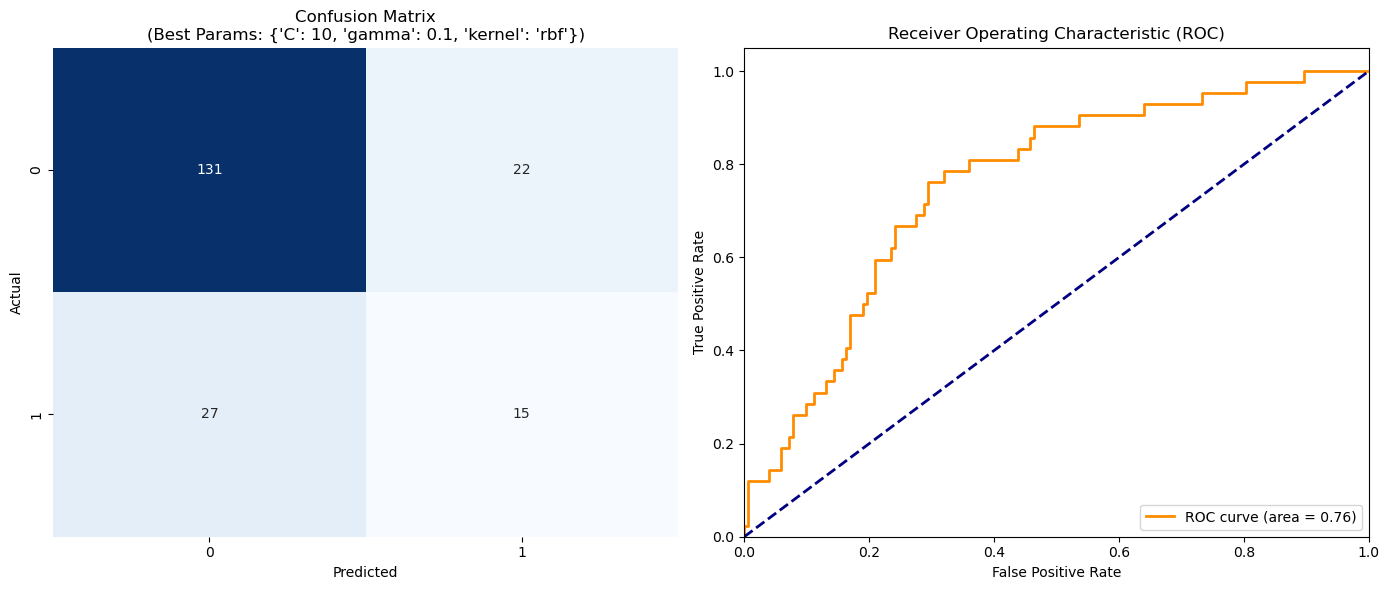

In [6]:
plt.figure(figsize=(14, 6))

# Visual 1: Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix\n(Best Params: {grid.best_params_})')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Visual 2: ROC Curve
plt.subplot(1, 2, 2)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()